## How can you reduce your carbon footprint after COP 26? 

1.	Which products contribute the most to your UK carbon emission footprint? (and which products are most important for predicting the UK carbon footprint?)
2.	Where do these products come from globally? 
3.	Is there a change over time in where products come from overall and for individual products? 


In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
sklearn.set_config(print_changed_only=True)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score


In [3]:
full_df = pd.read_excel('Data/---Consumption_emissions_March_21_final_accessible_rev.xlsx', sheet_name=None) #all data
#data source: https://www.gov.uk/government/statistics/uks-carbon-footprint
CO2_source = pd.read_excel('Data/CO2_emissions_source_region_1990_2018_KTonnes.xlsx') #summed over all products
CO2_products = pd.read_excel('Data/CO2_emission_by_final_product_1990_2018_KTonnes.xlsx') #summed over all regions


In [1]:
#CO2_products.columns

In [154]:
#Checking for missing values in each column:
nulls =set(CO2_products.columns[CO2_products.isnull().sum() != 0]) #sum of all nans, when isnull ==0 - no missing values are present
nulls #no missing values found

set()

## Question 1 - Which products contribute the most to your UK carbon emission footprint?

In [4]:
def changing_colour_for_top_contributors(contrib_df, df_feature_import):
    top_contrib_list = list(contrib_df['Product'].head(10))
    all_products = list(df_feature_import['Product'])

    all_colours = []
    for i in range(len(all_products)):
        if all_products[i] in top_contrib_list:
            colour = 'indianred'
        else:
            colour = 'lightgreen'
        all_colours.append(colour)

    return all_colours
    

Text(0.5, 0, 'Contribution to carbon emissions 1990-2018 (%)')

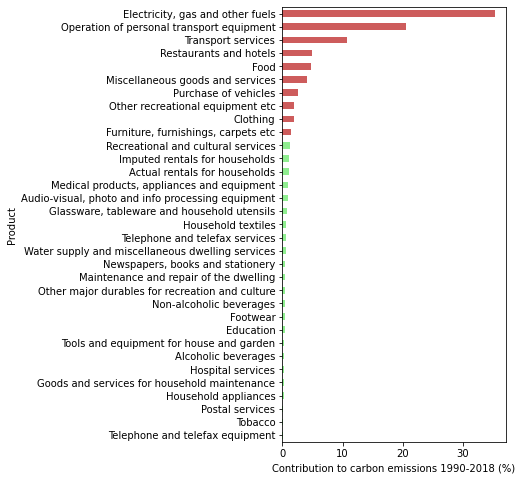

In [5]:
#Products that contribute the most to carbon emissions

CO2_products_crop = CO2_products.drop(columns=['Total', 'Unnamed: 0'])
contrib_df = CO2_products_crop.sum().to_frame().reset_index() #in 2018 (final year of data)
contrib_df = contrib_df.rename(columns= {'index': 'Product', 0:'Contribution'}) 
contrib_df['Contribution']= (contrib_df['Contribution'] / CO2_products.sum()['Total']) * 100


contrib_df = contrib_df.sort_values(by='Contribution',ascending=True)
top_contrib_df = contrib_df.sort_values(by='Contribution',ascending=False) #reversing order to select top contributors using head()
all_colours = changing_colour_for_top_contributors(top_contrib_df, contrib_df)

ax = contrib_df.plot(kind='barh', y='Contribution', x='Product',figsize=(4,8),legend='',color=all_colours)
ax.set_xlabel("Contribution to carbon emissions 1990-2018 (%)")


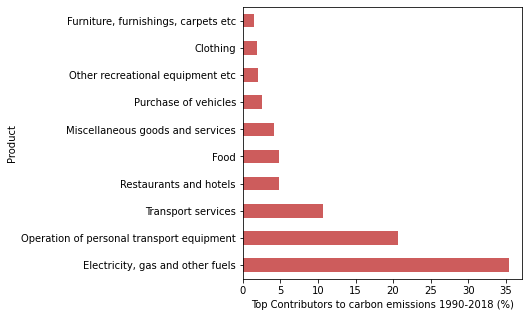

In [43]:
#These are the top 10 products which contribute the most to your carbon footprint:

contrib_df = contrib_df.sort_values(by='Contribution',ascending=False) #reversing order to select top contributors using head()

ax = contrib_df.head(10).plot(kind='barh', y='Contribution', x='Product',figsize=(5,5),legend='',color= 'indianred')
ax.set_xlabel("Top Contributors to carbon emissions 1990-2018 (%)")
#ax.grid()
plt.savefig('Plots/top_contrib_carbon_emission.png', dpi=300, bbox_inches='tight')

In [7]:
contrib_df.head(10)

,Product,Contribution
10,"Electricity, gas and other fuels",35.388619
20,Operation of personal transport equipment,20.583460
21,Transport services,10.678808
31,Restaurants and hotels,4.843647
0,Food,4.774118
32,Miscellaneous goods and services,4.157926
19,Purchase of vehicles,2.532619
27,Other recreational equipment etc,1.959444
4,Clothing,1.852681
11,"Furniture, furnishings, carpets etc",1.489342


### 2/3s of our UK carbon footprint is from electricity/gas/fuel and transport. 

The top contributing product (electricity, gas and other fuels) at 35% is unsurprising as it's our main source of energy followed by 
transport equipment and services (21% and 11%) - in total 68% (about 2/3s) .

It was interesting for me, restaurants and hotels followed as I previously would consider them 
as the highest contributors to my carbon footprint. 

Then food and purchase of vehicles which I'm not surprised by, we import most food and manufacturer our vehicles from all over the world.

Miscellaneous goods and services and other recreational equipment is not very helpful as it's ambiguous what it actually is.

Finally, I knew about clothing (especially fast fashion) but I hadn't previously thought about furniture/ furnishings and carpets, although 
these products are not everyday purchases and may be purchased infrequently.


## Question 1 extended - which products are most important for predicting the UK carbon footprint? 

In [305]:
y = CO2_products['Total']
X = CO2_products.drop(columns=['Total', 'Unnamed: 0'])
y.shape #29 observations
X.shape #29,33 , 33 features 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42)

In [306]:
np.mean(cross_val_score(LinearRegression(),X_train, y_train, cv=10))
#but more features than samples so use Ridge instead

0.9700161964172362

### Ridge

In [307]:
np.mean(cross_val_score(Ridge(), X_train, y_train, cv=10))

0.9700170835476289

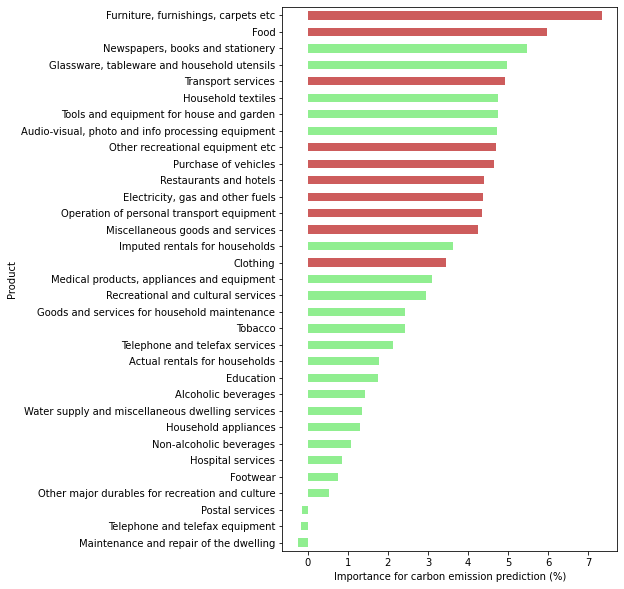

In [616]:
#Feature importance for Ridge regression prediction of carbon emissions:

ridge = Ridge().fit(X_train, y_train)
importance = ridge.coef_

df_feature_import = pd.DataFrame()
df_feature_import['Product'] = X_train.columns
df_feature_import['Importance'] = importance
df_feature_import = df_feature_import.sort_values(by='Importance',ascending=True)
#normalising:
df_feature_import['Importance'] = (df_feature_import['Importance']/df_feature_import['Importance'].sum())*100

all_colours = changing_colour_for_top_contributors(contrib_df, df_feature_import)
       
ax = df_feature_import.plot(kind='barh', y='Importance', x='Product',figsize=(6,10),legend='',color=all_colours)
ax.set_xlabel("Importance for carbon emission prediction (%)")
plt.savefig('Plots/feature_impor_predict_carbon_emission.png', dpi=300, bbox_inches='tight')

#Ridge regression highly ranks a lot of the top contributors of carbon emissions (as highlighted in red) in its prediction 
#therefore we can trust & understand the prediction


In [309]:
#Although the score is very high (~0.97) can we improve it using Grid Search? 

#We minimise the generalisation error (i.e. minimising the error between the training 
#and test data (overfitting) by considering the bias-variance tradeoff using GridSearchCV.
  
from sklearn.model_selection import GridSearchCV
param_grid = {'alpha': np.logspace(-2, 7, 14)}
print(param_grid)

{'alpha': array([1.00000000e-02, 4.92388263e-02, 2.42446202e-01, 1.19377664e+00,
       5.87801607e+00, 2.89426612e+01, 1.42510267e+02, 7.01703829e+02,
       3.45510729e+03, 1.70125428e+04, 8.37677640e+04, 4.12462638e+05,
       2.03091762e+06, 1.00000000e+07])}


In [310]:
grid = GridSearchCV(Ridge(), param_grid, cv=10, return_train_score=True)
grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-02, 4.92388263e-02, 2.42446202e-01, 1.19377664e+00,
       5.87801607e+00, 2.89426612e+01, 1.42510267e+02, 7.01703829e+02,
       3.45510729e+03, 1.70125428e+04, 8.37677640e+04, 4.12462638e+05,
       2.03091762e+06, 1.00000000e+07])},
             return_train_score=True)

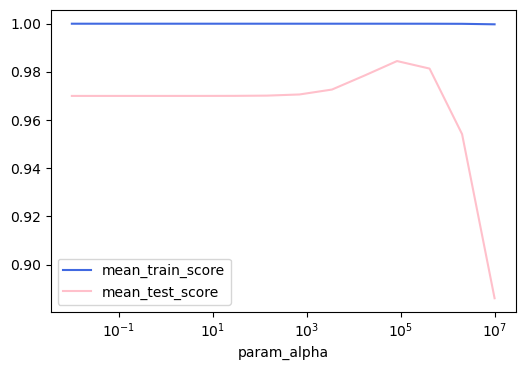

In [552]:

plt.figure(dpi=100)
results = pd.DataFrame(grid.cv_results_)
results.plot('param_alpha', 'mean_train_score', ax=plt.gca(),c='royalblue')
results.plot('param_alpha', 'mean_test_score', ax=plt.gca(),c='pink')

plt.legend()
plt.xscale("log")

In [313]:
print(grid.best_params_) #this is alpha value when the test score is at its peak
print(grid.best_score_)
#The score increases slightly from 0.97 to 0.98 after tuning the hyperparameters

{'alpha': 83767.76400682924}
0.98449317314348


### Lasso

In [314]:
from sklearn.linear_model import Lasso
#meant to be better at picking out the best predictors

lasso = Lasso().fit(X_train, y_train)

print("Training set score: {:.2f}".format(lasso.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lasso.score(X_test, y_test)))
print("Number of features used:", np.sum(lasso.coef_ != 0))

Training set score: 1.00
Test set score: 0.97
Number of features used: 33


Text(0.5, 0, 'Importance for carbon emission prediction (%)')

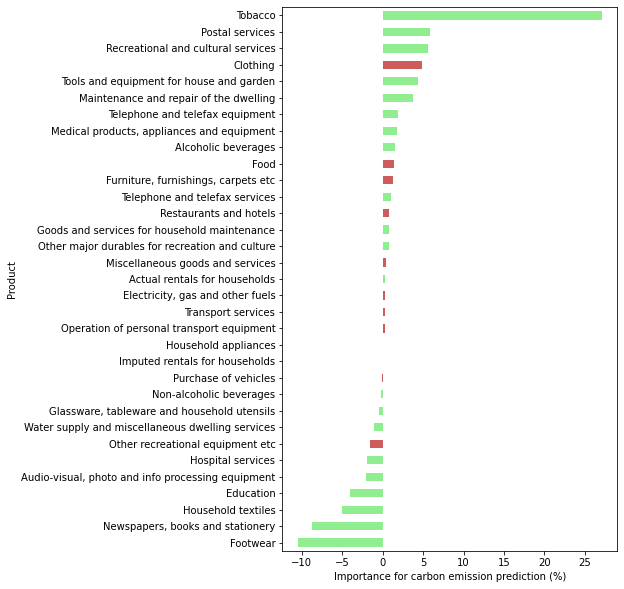

In [335]:
#Feature importance for Lasso regression prediction of carbon emissions:

importance = lasso.coef_
df_feature_import = pd.DataFrame()
df_feature_import['Product'] = X_train.columns
df_feature_import['Importance'] = importance
df_feature_import = df_feature_import.sort_values(by='Importance',ascending=True)
#normalising:
df_feature_import['Importance'] = ((df_feature_import['Importance']/np.abs(df_feature_import['Importance']).sum()))*100

all_colours = changing_colour_for_top_contributors(contrib_df, df_feature_import)

ax = df_feature_import.plot(kind='barh', y='Importance', x='Product',figsize=(6,10),legend='',color=all_colours)
ax.set_xlabel("Importance for carbon emission prediction (%)")

#Lasso reduces the importance of a lot of the predictors and focuses on Tobacco and Footwear. 
#These are amongst the lowest contributors to carbon emissions therefore it is suggested Lasso prediction is not a reliable method here.

## Question 2 - Where do the top contributors to UK carbon emissions come from globally?

In [9]:
top_contrib_list = list(contrib_df['Product'].head(10))
#drop 'Miscellaneous goods and services' and 'Other recreational equipment etc' 
#as not useful informationtop_contrib_list.remove('Miscellaneous goods and services')
top_contrib_list.remove('Other recreational equipment etc')
top_contrib_list.remove('Miscellaneous goods and services')
top_contrib_list2 = top_contrib_list.copy()
top_contrib_list2

['Electricity, gas and other fuels',
 'Operation of personal transport equipment',
 'Transport services',
 'Restaurants and hotels',
 'Food',
 'Purchase of vehicles',
 'Clothing',
 'Furniture, furnishings, carpets etc']

In [10]:
df_2018 = full_df['co2_2018_reg'].copy()
df_2018 = df_2018.rename(columns={'Unnamed: 0':'Country'})
top_contrib_list2.append('Country')
source_of_top_contrib = df_2018[top_contrib_list2]
source_of_top_contrib

,"Electricity, gas and other fuels",Operation of personal transport equipment,Transport services,Restaurants and hotels,Food,Purchase of vehicles,Clothing,"Furniture, furnishings, carpets etc",Country
0,51140.654932,7967.569430,37708.950093,11291.499734,8639.015811,969.203410,153.046152,378.112677,UK
1,16.045031,49.430435,56.455094,50.130091,161.923164,50.602105,16.785623,41.761288,Brazil
2,285.091083,2563.146088,2078.477449,402.417846,389.861831,216.115027,91.820023,101.534221,Russia
3,79.353573,431.869676,478.346111,982.240918,584.300136,292.934607,328.970188,254.503049,India
4,313.331720,928.016404,716.344363,684.704609,881.926637,1043.220996,1328.081333,1398.114737,China
5,24.574546,149.896234,264.703920,515.113915,743.859056,465.455649,38.702323,41.519454,South Africa
6,120.208301,595.466531,2061.898759,370.941617,453.766170,311.404001,150.082297,510.297369,USA
7,39.594065,129.929213,516.712724,85.640841,80.141557,288.039914,57.978655,57.765530,Japan
8,3087.626951,4888.108670,13044.630864,3360.128706,5229.336858,2474.550469,755.889733,1033.662484,Rest of the EU
9,1925.459006,2025.744101,606.898983,481.931910,469.987028,206.718011,54.464780,110.529468,Rest of Europe


In [11]:
colour_ranking = ['lightblue','lightblue','lightblue','royalblue','royalblue','royalblue',
               'royalblue', 'royalblue', 'royalblue', 'royalblue', 'royalblue', 
               'royalblue', 'darkblue','darkblue','darkblue']

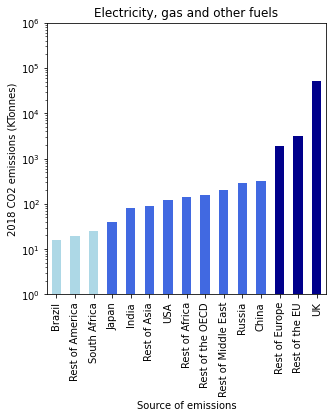

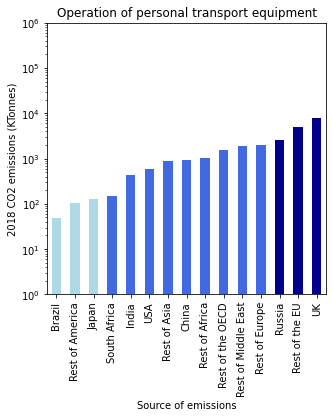

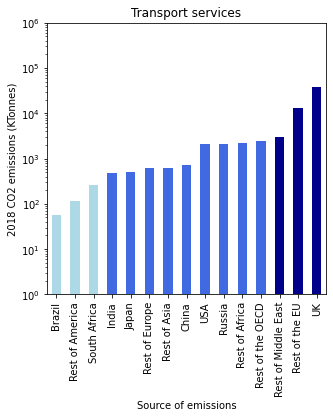

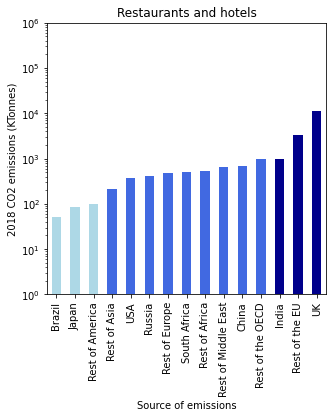

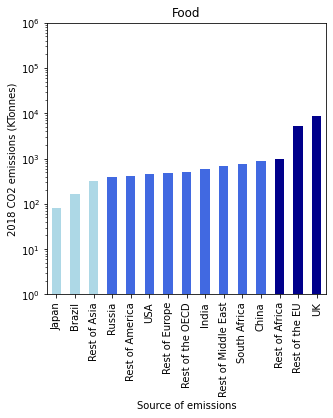

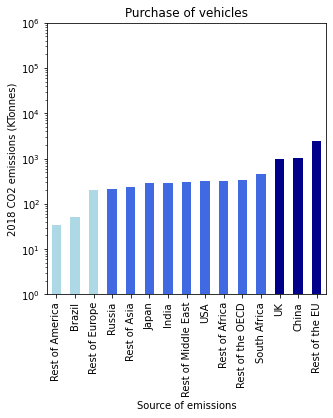

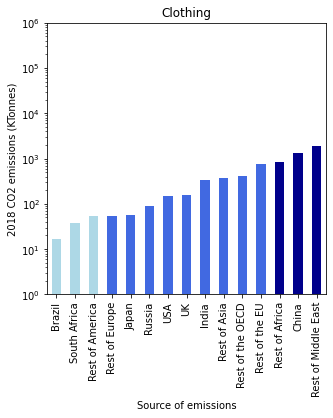

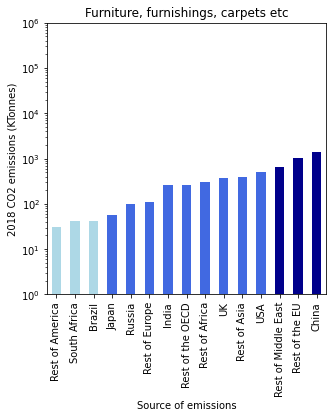

In [44]:
def make_bar_chart_of_emission_source_for_single_product(source_of_top_contrib, product_name):
    
    data = source_of_top_contrib[[product_name,'Country']].sort_values(by=product_name)
    ax = data.plot(kind='bar',y=product_name, x='Country', figsize=(5,5),legend='',color=colour_ranking)
    ax.set_ylabel("2018 CO2 emissions (KTonnes)")
    ax.set_xlabel("Source of emissions")
    ax.set_yscale('log')
    ax.set_title(product_name)
    ax.set_ylim(1,1E6)
    plt.savefig('Plots/source_carbon_emissions_'+product_name+'.png', dpi=300, bbox_inches='tight')
    return

for product_name in range(len(top_contrib_list)):
    
    make_bar_chart_of_emission_source_for_single_product(source_of_top_contrib, top_contrib_list[product_name])

Despite the highest emissions found inside the UK, we explore the origins of the top contributing products to our CO2 emissions in 2018 outside the UK for electricity/ fuel, transport and restaurants/hotels. It's interesting to see the carbon footprint from the top contributor 'electricity, gas and other fuels' is concentrated in Europe, while the largest footprint of emissions from transport equipment and services are found in Europe, Russia and the Middle East. The high restaurant and hotel emissions originate in India and Europe, while most food emissions originate in Africa and Europe.

Instead, the carbon emissions from the purchase of vehicles, clothing and furniture/ furnishings are actually higher outside the UK than within. The emissions abroad than found in the UK from vehicle manufacturing are highest in China and Europe, while the highest clothing emissions are found in the Middle East, China, Africa, Europe and India. These are all larger than found in the UK. Again the highest emissions from furniture/ furnishings are found in China, Europe, the Middle East, USA and Asia.

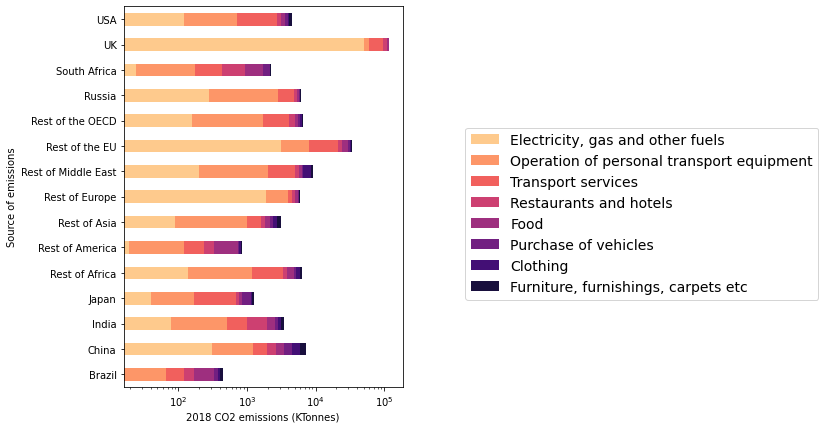

In [42]:
#Another way to visualise the contribution of these products to the total UK carbon emissions 
#from each country is shown:

import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
colors = sns.color_palette("magma_r", n_colors=len(top_contrib_list))
cmap1 = LinearSegmentedColormap.from_list("my_colormap", colors)

source_of_top_contrib2 = source_of_top_contrib.set_index('Country').sort_values(by='Country')
ax = source_of_top_contrib2.plot(kind='barh', stacked=True,figsize=(5,7),colormap=cmap1)
ax.set_xlabel("2018 CO2 emissions (KTonnes)")
ax.set_ylabel("Source of emissions")
ax.set_xscale('log')
ax.legend(bbox_to_anchor=(1.2, 0.7),fontsize=14)
plt.savefig('Plots/source_top_contrib_carbon_emission.png', dpi=300, bbox_inches='tight')


Unsurprisingly the UK carbon footprint is dominated by UK emissions, with a large proportion taken up by electricity/ fuel products. 
Instead Brazil doesn't contribute to UK emissions from electricity/ fuel products and instead emissions mainly from transport, food and restaurants/ hotels. 

## Question 3 - Does the source of the top contributing products to carbon emissions change over time? 

In [15]:
source_of_top_contrib_2018 = source_of_top_contrib  #from above
#adding 1990 data:
df_1990 = full_df['co2_1990_reg'].copy()
df_1990 = df_1990.rename(columns={'Unnamed: 0':'Country'})
top_contrib_list3 = top_contrib_list.copy()
top_contrib_list3.append('Country')
source_of_top_contrib_1990 = df_1990[top_contrib_list3]

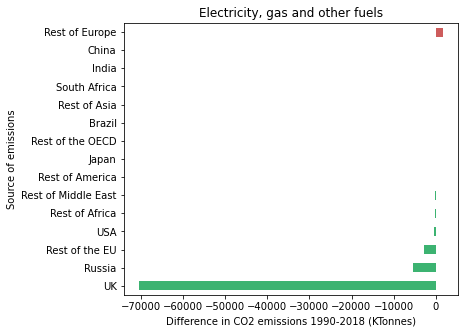

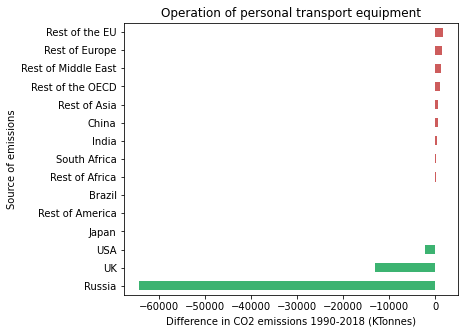

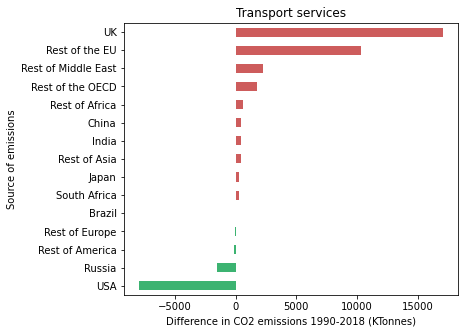

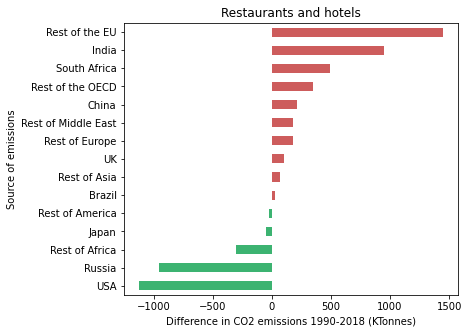

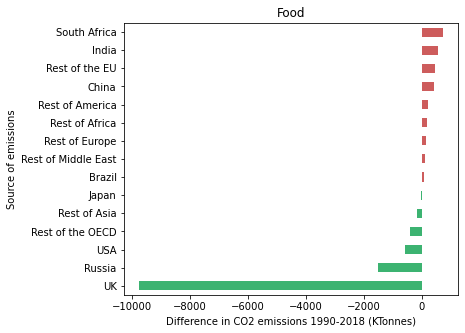

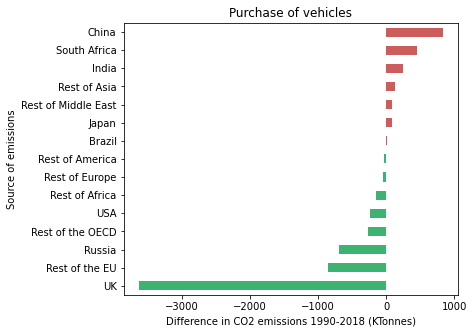

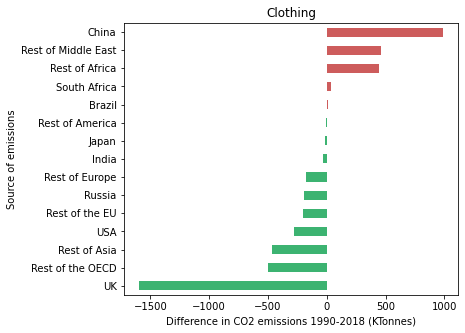

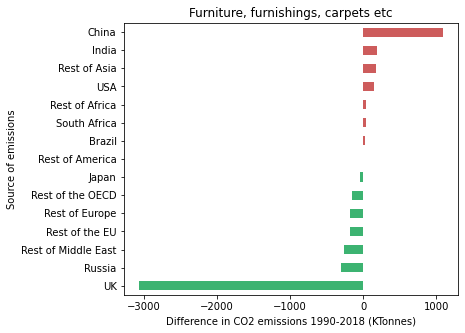

In [35]:

 def make_bar_chart_of_emission_source_for_single_product(source_of_top_contrib_2018, source_of_top_contrib_1990, product_name):
    
    df_source_2018_min_1990 = pd.DataFrame()
    df_source_2018_min_1990['Emission_diff'] = source_of_top_contrib_2018[product_name] - source_of_top_contrib_1990[product_name]
    df_source_2018_min_1990['Country'] = source_of_top_contrib_2018['Country']
    df_source_2018_min_1990 #a negative number means a reduction over time 
    
    data = df_source_2018_min_1990.sort_values(by='Emission_diff')
    ax = data.plot(kind='barh',y='Emission_diff', x='Country', figsize=(6,5),legend='',
                    color=(data['Emission_diff'] > 0).map({True: 'indianred', False: 'mediumseagreen'}))
    ax.set_xlabel("Difference in CO2 emissions 1990-2018 (KTonnes)")
    ax.set_ylabel("Source of emissions")
    ax.set_title(product_name)
#     if product_name == 'Electricity, gas and other fuels' or product_name == 'Operation of personal transport equipment':
#         ax.set_xlim(-80000,10000)
#     elif product_name == 'Transport services' or product_name == 'Food':
#         ax.set_xlim(-10000,20000)
#     else:
#         ax.set_xlim(-1800,1500)
#   difficult to visualise when changing xlimits to be consistent for each plot so commented out

    plt.savefig('Plots/diff_carbon_emission_1990_2018_'+product_name+'.png', dpi=300, bbox_inches='tight')
    return

for product_name in range(len(top_contrib_list)):
    
    make_bar_chart_of_emission_source_for_single_product(source_of_top_contrib_2018, source_of_top_contrib_1990, top_contrib_list[product_name])

It's great to see some large reductions in UK CO2 emissions between 1990 to 2018, originating from the UK, particularly in electricity/ fuel, vehicle purchases, food, clothing and furniture/ furnishing emissions, presumably as we turn to renewable energy, increase our clothing and furniture imports and make UK farming more efficient. Instead, there's an increase in the emissions from the purchase of vehicles from China, South Africa and India, and from clothing in China, the Middle East and Africa.
 
On the other hand, transport emissions originating from Russia and the USA have also reduced although, they have increased from the UK itself and from Europe. And finally, there has been a shift in the carbon footprint from restaurants and hotels with reductions from Russia and the USA but a large increases  in emissions from Europe, India, South Africa and the Middle East. This needs more data to understand this trend and draw conclusions from.


### How can you reduce your carbon footprint?

From this data,
 - Reduce energy consumption and travel less
 - Also buy furniture/ vehicles infrequently and buy food locally

On the plus side from this data, keep enjoying alcoholic beverages (your favourite glass of wine) with a good book! 
